In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from nymeria.data_provider import NymeriaDataProvider
from nymeria.recording_data_provider import AriaStream
from nymeria.xsens_constants import XSensConstants
from projectaria_tools.core.stream_id import StreamId
from projectaria_tools.core.sophus import SE3

In [3]:
def bones_to_unique_joints(b): 
    p=np.zeros((XSensConstants.num_parts,3),np.float32)
    for i,(c,pa) in enumerate(b):
        p[i+1]=c
        if i==0:p[0]=pa
    return p
class TimeAlignedLoader:
    def __init__(self,dp,fps=10,downsample_rgb=True):
        self.dp=dp
        self.down=downsample_rgb
        self.dt=int(1e9/fps)
        self.t0,self.t1=dp.timespan_ns
        self.rec=dp.recording_head
        self.sid=StreamId(AriaStream.camera_rgb.value)
        self.vrs=self.rec.vrs_dp
        self.cam=self.vrs.get_device_calibration().get_camera_calib("camera-rgb")
    def world_to_camera(self,P,Twd,Tdc):
        Rwd=Twd.rotation().to_matrix(); twd=np.asarray(Twd.translation()).reshape(3)
        Rdc=Tdc.rotation().to_matrix(); tdc=np.asarray(Tdc.translation()).reshape(3)
        Rwc=Rwd@Rdc; twc=Rwd@tdc+twd
        return (Rwc.T@(P.T-twc[:,None])).T
    def get_frame(self,i):
        t=self.t0+i*self.dt
        rgb_data=self.dp.get_synced_rgb_videos(t)["recording_head"][0]
        rgb=rgb_data.to_numpy_array()
        if self.down: rgb=rgb[::2,::2]
        poses=self.dp.get_synced_poses(t)
        joints_w=bones_to_unique_joints(poses["xsens"])
        T_W_D=poses["recording_head"].transform_world_device
        T_D_C=self.cam.get_transform_device_camera()
        joints_c=self.world_to_camera(joints_w,T_W_D,T_D_C)
        uv=[]
        for p in joints_c:
            q=self.cam.project(p)
            if q is None: uv.append([-1.,-1.])
            else:
                u,v=q
                if self.down:u,v=u/2.,v/2.
                uv.append([u,v])
        return rgb,np.asarray(uv,np.float32),joints_w


In [7]:
SEQ_DIR = Path(r"C:\Users\Damir\nymeria_dataset\d\20230622_s0_john_solomon_act2_8urygm")
FPS_SAMPLE=10
DOWNSAMPLE_RGB=True
dp=NymeriaDataProvider(sequence_rootdir=SEQ_DIR,load_wrist=False,load_observer=False)
loader=TimeAlignedLoader(dp,fps=FPS_SAMPLE,downsample_rgb=DOWNSAMPLE_RGB)

2025-05-14 13:55:38.741 | INFO     | nymeria.body_motion_provider:__init__:31 - loading xsens from npzfile='C:\\Users\\Damir\\nymeria_dataset\\d\\20230622_s0_john_solomon_act2_8urygm\\body\\xdata.npz'
2025-05-14 13:55:39.166 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_qWXYZ', v.shape=(144289, 92)
2025-05-14 13:55:39.167 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_tXYZ', v.shape=(144289, 69)
2025-05-14 13:55:39.168 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_velocity', v.shape=(144289, 69)
2025-05-14 13:55:39.170 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_acceleration', v.shape=(144289, 69)
2025-05-14 13:55:39.171 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_angularVelocity', v.shape=(144289, 69)
2025-05-14 13:55:39.172 | INFO     | nymeria.body_motion_provider:__init__:34 - k='segment_angularAcceleration', v.shape=(144289, 69)
2025-05-14 13:55:39.172 | INFO     | nymeria.b

C:\Users\Damir\AppData\Local\Temp\ipykernel_13268\1361730839.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap("turbo",XSensConstants.num_parts)


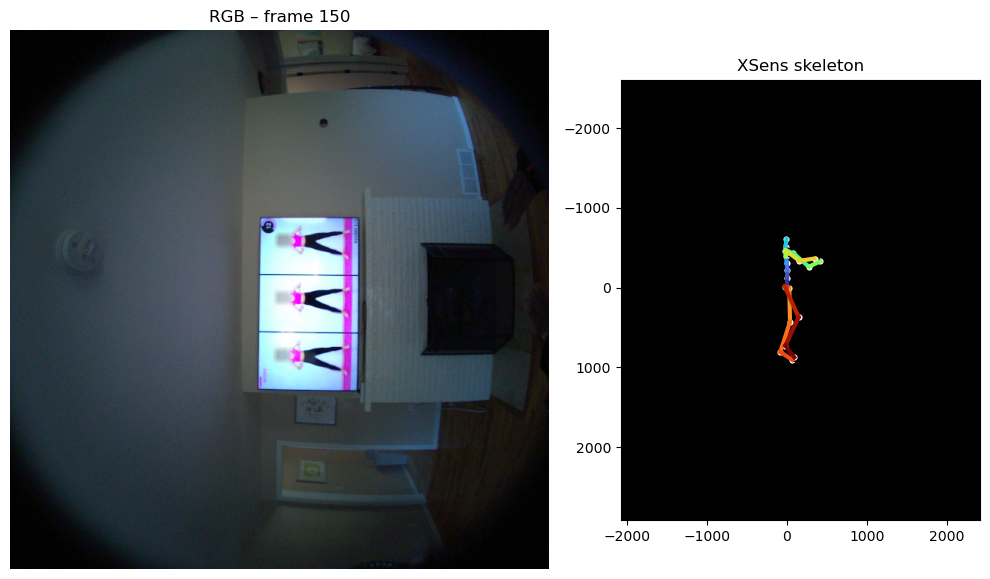

In [14]:
FRAME_IDX=150
rgb_img,joints_2d,joints_world=loader.get_frame(FRAME_IDX)
parents=np.array([-1,0,1,2,3,4,5,4,7,8,9,4,11,12,13,0,15,16,17,0,19,20,21])
cmap=cm.get_cmap("turbo",XSensConstants.num_parts)
colors=cmap(np.arange(XSensConstants.num_parts))[:,:3]
u,v=joints_2d[:,0],joints_2d[:,1]
h,w=rgb_img.shape[:2]
fig,(axL,axR)=plt.subplots(1,2,figsize=(10,6),gridspec_kw=dict(width_ratios=[3,2]))
axL.imshow(rgb_img); axL.axis("off"); axL.set_title(f"RGB – frame {FRAME_IDX}")
axR.set_facecolor("k"); axR.set_title("XSens skeleton"); axR.set_aspect("equal"); axR.invert_yaxis()
valid=u>=0
if valid.any():
    for j,p in enumerate(parents):
        if p<0 or u[j]<0 or u[p]<0:continue
        axR.plot([u[j],u[p]],[v[j],v[p]],color=colors[j],lw=3)
    axR.scatter(u[valid],v[valid],c="w",s=30,edgecolors="k")
    axR.set_xlim(0,w); axR.set_ylim(h,0)
else:
    o=joints_world[0]; x=(joints_world-o)[:,0]*1000; y=-(joints_world-o)[:,2]*1000
    for j,p in enumerate(parents):
        if p<0:continue
        axR.plot([x[j],x[p]],[y[j],y[p]],color=colors[j],lw=3)
    axR.scatter(x,y,c="w",s=30,edgecolors="k")
    m=2000; axR.set_xlim(x.min()-m,x.max()+m); axR.set_ylim(y.max()+m,y.min()-m)
plt.tight_layout(); plt.show()